In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

Alpha for action 0: 1.0
Beta for action 0: 1.0
Sample values for action 0 (first few): [0.91794615 0.70758067 0.32813621 0.51901997 0.15706957]
Action Prob Dist (first few samples):
[[0.91794615 0.45659572 0.00132035 0.67083576 0.73654937 0.09246039
  0.23447316 0.35218736 0.72929896 0.08622436]
 [0.70758067 0.89441538 0.64665501 0.59546391 0.29401164 0.13606455
  0.23270561 0.03292719 0.73725777 0.8886095 ]
 [0.32813621 0.24741584 0.73028652 0.02855628 0.31304678 0.54622288
  0.8363287  0.06408669 0.14050184 0.07990039]
 [0.51901997 0.54162543 0.32341419 0.18118973 0.61795779 0.97701026
  0.60887089 0.27761448 0.31594349 0.64099876]
 [0.15706957 0.31632306 0.0700183  0.48135291 0.96804099 0.11963598
  0.94637569 0.17041554 0.4123782  0.267924  ]]
Action Distribution (first few samples):
[[[0.21457911]
  [0.10673382]
  [0.00030864]
  [0.15681458]
  [0.17217579]
  [0.02161354]
  [0.05481045]
  [0.08232732]
  [0.17048094]
  [0.02015581]]

 [[0.13697696]
  [0.17314534]
  [0.12518267]
  [0

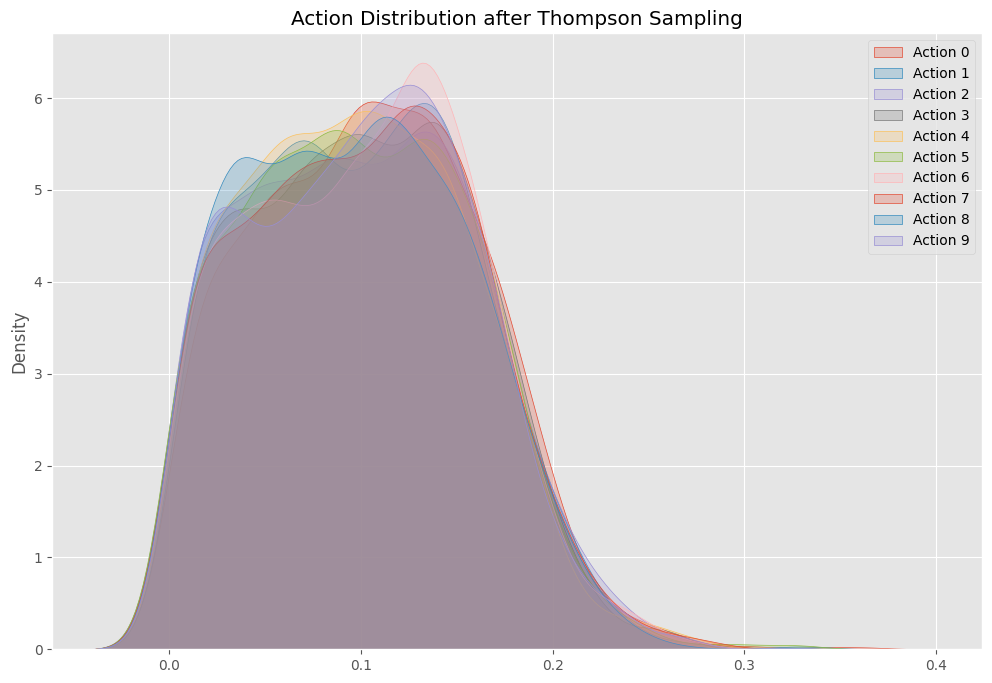

/Users/niekvandergaag/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


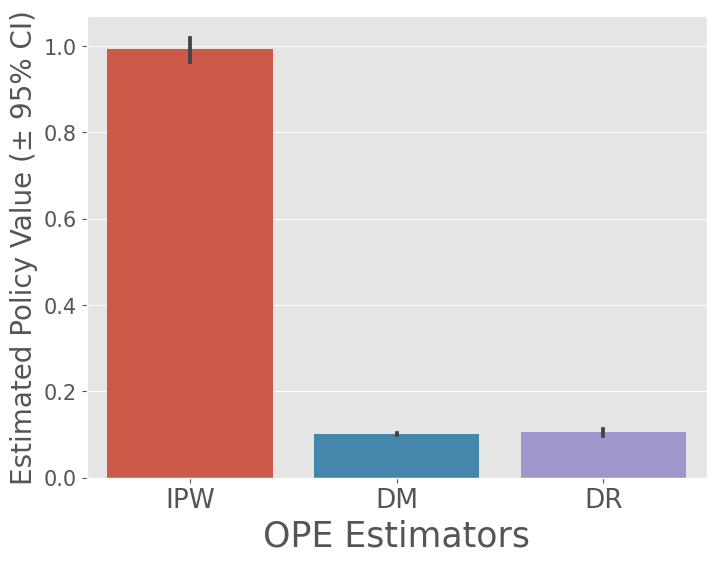

In [13]:
# Class for TS
class ThompsonSamplingTree(BaseEstimator, ClassifierMixin):
    def __init__(self, n_actions, base_model=None, random_state=None):
        self.n_actions = n_actions
        self.base_model = base_model if base_model is not None else DecisionTreeClassifier()
        self.random_state = random_state

    def fit(self, X, y):
        self.models = []
        self.action_counts = np.zeros(self.n_actions)
        self.success_counts = np.zeros(self.n_actions)
        
        for action in range(self.n_actions):
            action_X = X[y == action]
            action_y = np.ones(len(action_X))
            if len(action_X) == 0:
                action_X = X
                action_y = np.zeros(len(X))
            model = self.base_model.fit(action_X, action_y)
            self.models.append(model)
        
        return self

    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], self.n_actions))
        for action, model in enumerate(self.models):
            action_proba = model.predict_proba(X)
            if action_proba.shape[1] == 1:
                proba[:, action] = action_proba[:, 0]  # we use [:, 0] instead of 0
            else:
                proba[:, action] = action_proba[:, 1]
        return proba

    def sample_action(self, X):
        proba = self.predict_proba(X)
        samples = np.zeros((X.shape[0], self.n_actions))
        for action in range(self.n_actions):
            alpha = self.success_counts[action] + 1
            beta_value = self.action_counts[action] - self.success_counts[action] + 1
            if alpha <= 0 or beta_value <= 0:
                alpha, beta_value = 1, 1
            samples[:, action] = np.random.beta(alpha, beta_value, size=X.shape[0])
            # for debugging, i print alpha, beta, and sample values
            if action == 0:  # Print for the first action as an example
                print(f"Alpha for action {action}: {alpha}")
                print(f"Beta for action {action}: {beta_value}")
                print(f"Sample values for action {action} (first few): {samples[:5, action]}")
        action_prob_dist = proba * samples
        print("Action Prob Dist (first few samples):")
        print(action_prob_dist[:5])
        action_prob_dist_sum = action_prob_dist.sum(axis=1, keepdims=True)
        action_prob_dist_sum[action_prob_dist_sum == 0] = 1  # Avoid division by zero
        action_prob_dist /= action_prob_dist_sum
        action_dist = np.zeros((X.shape[0], self.n_actions, 1))
        action_dist[:, :, 0] = action_prob_dist
        return action_dist

    def update(self, X, actions, rewards):
        for i, action in enumerate(actions):
            self.action_counts[action] += 1
            self.success_counts[action] += rewards[i]
            self.models[action].fit(X[i].reshape(1, -1), [rewards[i]])

# prepare the multi-class dataset
X, y = load_digits(return_X_y=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to bandit data
n_actions = len(np.unique(y))

# Generate propensity scores assuming a uniform random policy
pscore = np.ones(X_scaled.shape[0]) / n_actions

# Train the custom Thompson Sampling policy with Decision Tree
ts_policy = ThompsonSamplingTree(n_actions=n_actions, base_model=DecisionTreeClassifier(random_state=12345))
ts_policy.fit(X_scaled, y)

# Simulate actions using the trained policy
action_dist = ts_policy.sample_action(X_scaled)

# Debugging: Print action distributions to check for variance
print("Action Distribution (first few samples):")
print(action_dist[:5])

# Add small epsilon to avoid zero probabilities
epsilon = 1e-6
action_dist = np.maximum(action_dist, epsilon)
action_dist /= action_dist.sum(axis=1, keepdims=True)

# Debugging: Check if any action_dist has zero variance
for action in range(n_actions):
    action_data = action_dist[:, action, 0]
    print(f"Action {action} variance: {np.var(action_data)}")

# Visualization
plt.figure(figsize=(12, 8))
for action in range(n_actions):
    action_data = action_dist[:, action, 0]
    if np.var(action_data) > 0:
        sns.kdeplot(action_data, label=f'Action {action}', fill=True)
    else:
        print(f"Skipping density plot for Action {action} due to zero variance.")
plt.title("Action Distribution after Thompson Sampling")
plt.legend()
plt.show()

# Fit a regression model for Direct Method (DM)
regression_model = LogisticRegression(max_iter=5000)
regression_model.fit(X_scaled, y)
estimated_rewards_by_reg_model = regression_model.predict_proba(X_scaled)

# Ensure estimated_rewards_by_reg_model is 3D array with the correct shape
n_rounds, n_arms = estimated_rewards_by_reg_model.shape
estimated_rewards_by_reg_model = estimated_rewards_by_reg_model.reshape((n_rounds, n_arms, 1))

# Perform Off-Policy Evaluation
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW, DirectMethod as DM, DoublyRobust as DR

bandit_feedback = {
    "n_rounds": X_scaled.shape[0],
    "context": X_scaled,
    "action": y,
    "reward": np.random.binomial(1, estimated_rewards_by_reg_model.max(axis=1).flatten()),
    "pscore": pscore,
    "position": np.zeros(X_scaled.shape[0], dtype=int)  # Adding the "position" key
}

ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[IPW(), DM(), DR()]
)

# Visualize OPE results
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)

plt.show()
